In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 14 September 2023
# Description:
#     this script obtain and save the 1000m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates


In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load ice draft to create masks
di = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [4]:
## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [5]:
h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

We must make sure that this latitude range is so that the t-cells are always south and west of the u-cells.
This is important because the meridional and zonal transports occur on different grids to each other. We can check this by loading the u-cell and t-cell coordinates.

We choose this convention so that later on when we create numpy grids of where the contour is and in what direction the contour goes.

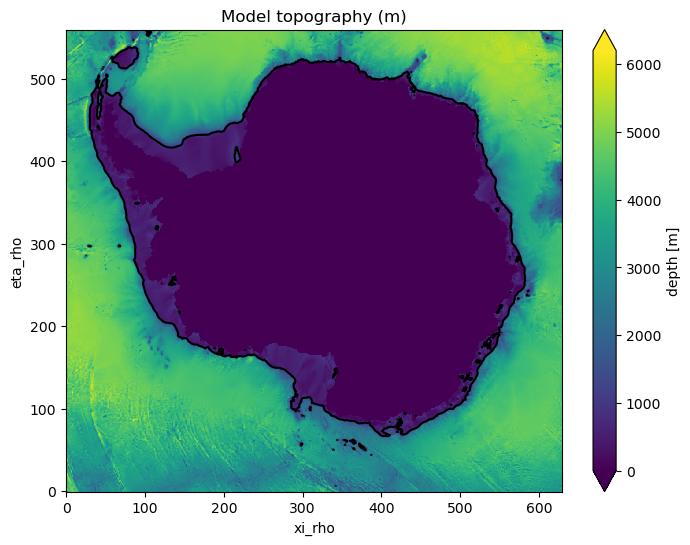

In [6]:
# contour: dg.h
contour_depth = 1000.

fig = plt.figure(figsize = (8, 6))
h.plot(extend='both', cbar_kwargs={'label': "depth [m]"})
h.plot.contour(levels = [contour_depth], colors = 'k', linestyles = '-')
plt.title('Model topography (m)');
plt.show()

In [7]:
## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

In [8]:
# # first save all contours in individual plot to scam for the number of the desired contour:

# for cc in np.arange(0,211):
#     fig = plt.figure(figsize = (8, 6))
#     count = cc
#     x_contour = []
#     y_contour = []

#     # Create the contour:
#     sc = plt.contour(h, levels=[contour_depth])
#     for collection in sc.collections:
#         for path in collection.get_paths():
#             # print(collection.get_paths())
        
#             count += 1
#             if count ==  212:
#                 # Write down the lat/lon indices
#                 for ii in range(np.size(path.vertices[:,0])):
#                     x_contour.append(int(np.round(path.vertices[ii][0])))
#                     y_contour.append(int(np.round(path.vertices[ii][1])))

#     plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');
#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/waom10extend_h=1000m_contour_cc=" + str(cc) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

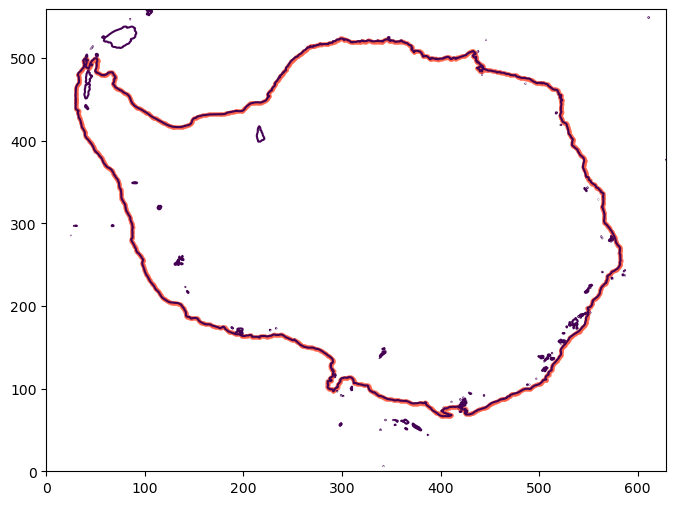

In [9]:
fig = plt.figure(figsize = (8, 6))
count = 198 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())
        
        count += 1
        if count ==  212:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

## SHOULD I SMOOTH IT? PROBABLY YES!

Processing
Now process these coordinates to make sure there are no double ups.

In [10]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [11]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [12]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

Due to the discrete grid, the values on our contour are not exactly the same. We check this makes sense -- if this plot is blank, then something has gone wrong.

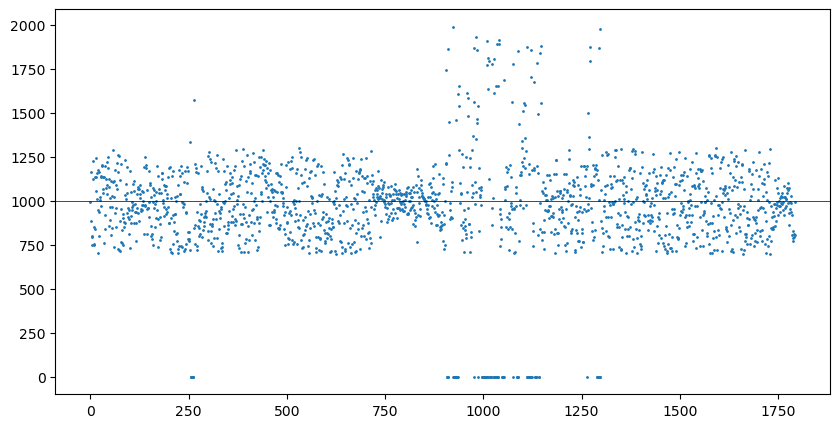

In [13]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

Get lat and lon along the contour


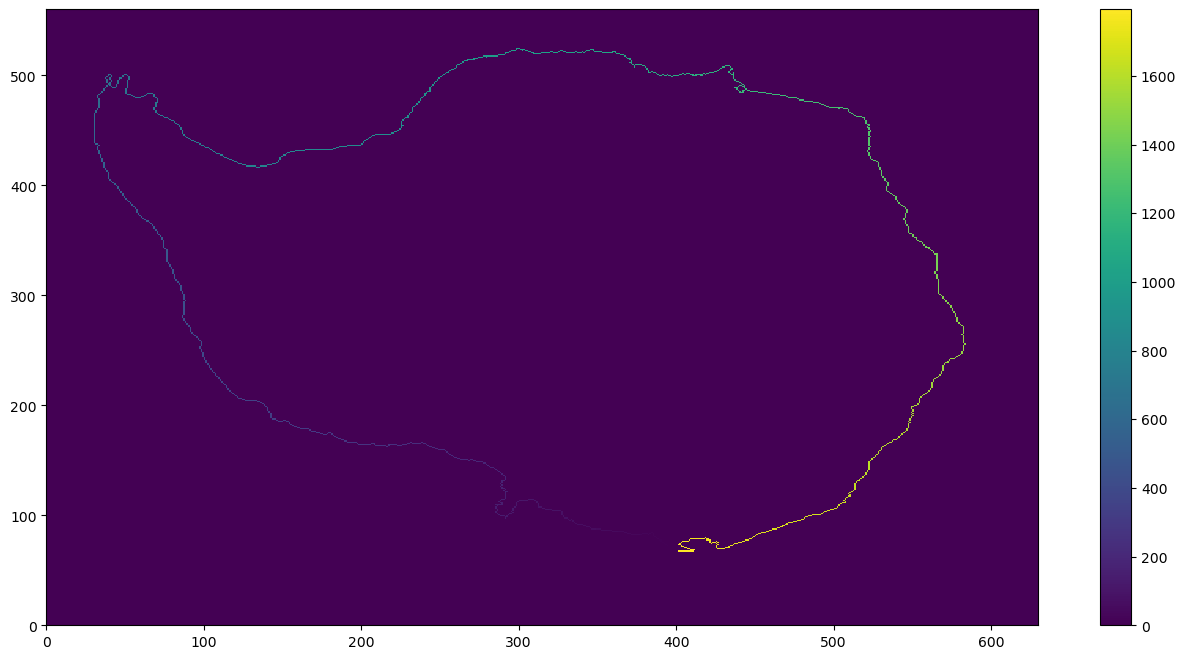

In [14]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
    
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
    lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]
    
# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii
    
contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
    
plt.figure(1, figsize=(16, 8))
plt.pcolormesh(contour_mask)
plt.colorbar()

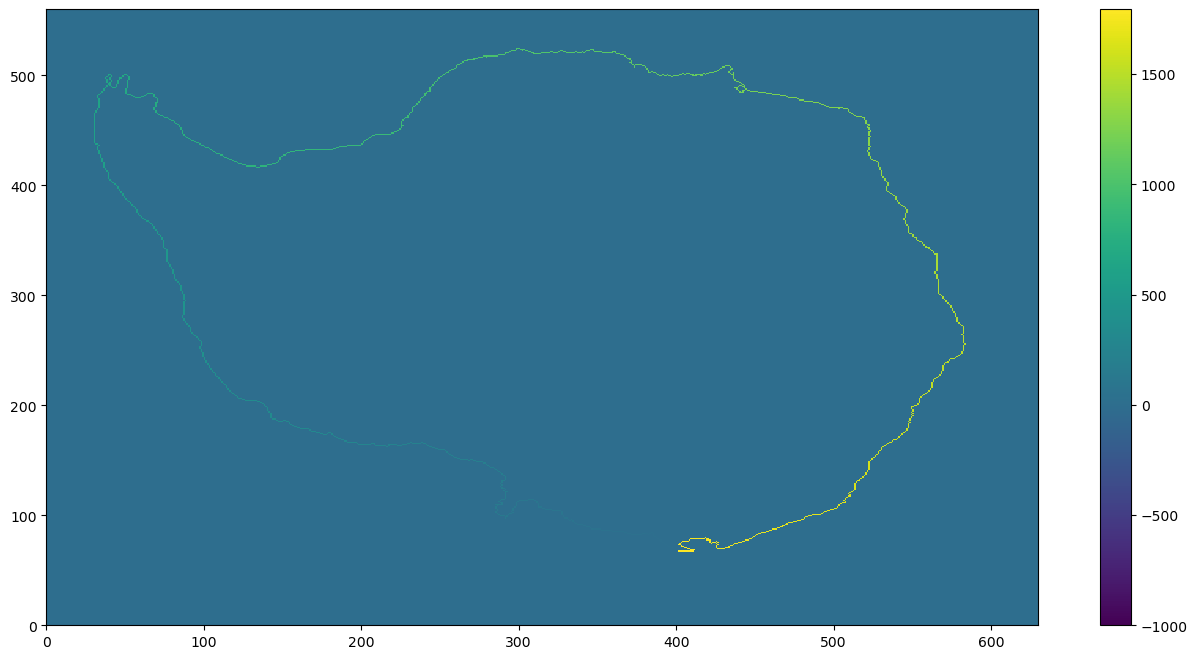

In [15]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

plt.figure(1, figsize=(16, 8))
plt.pcolormesh(contour_masked_above)
plt.colorbar()

# Create mask

Now we create a mask below contour so that the direction of the contour can be determined

Remark on computational inefficiency

Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.

See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

In [16]:
print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

(560, 630) (560, 630)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


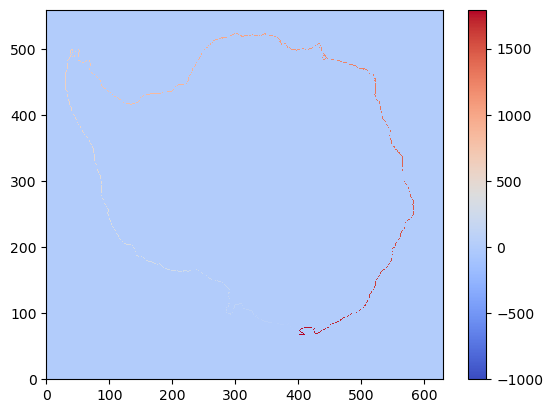

In [17]:

plt.pcolormesh(contour_masked_above, cmap='coolwarm')
plt.colorbar()

In [18]:
# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1 
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

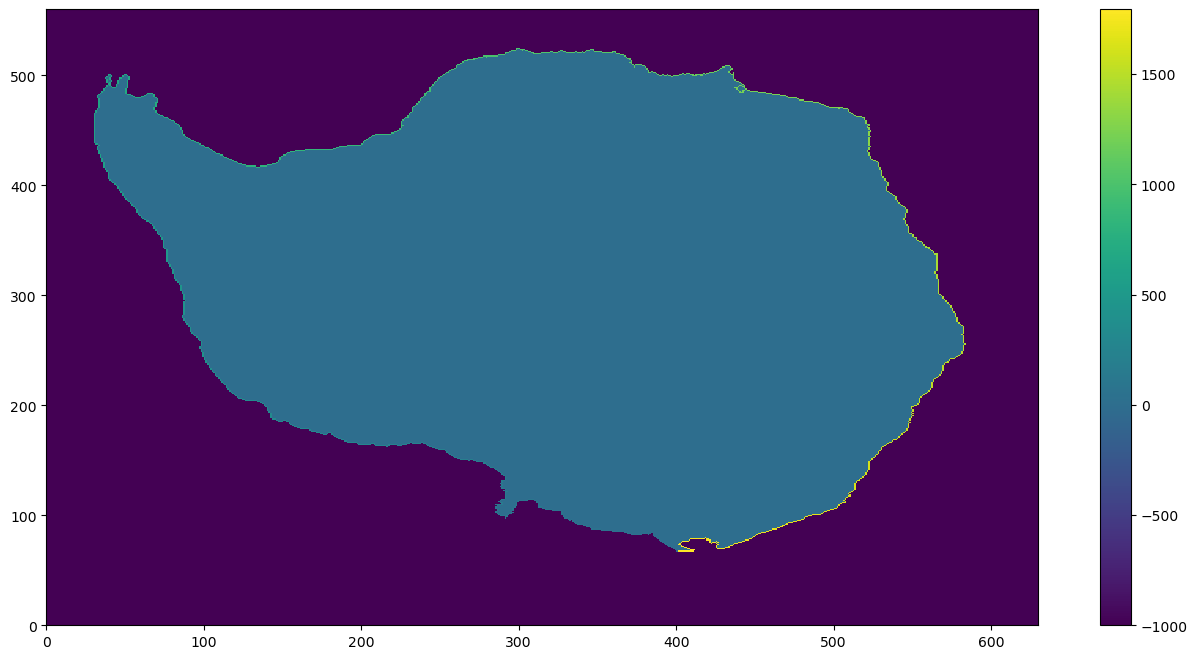

In [19]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(contour_masked_above)
plt.colorbar()

In [20]:
contour_masked_above.shape

(560, 630)

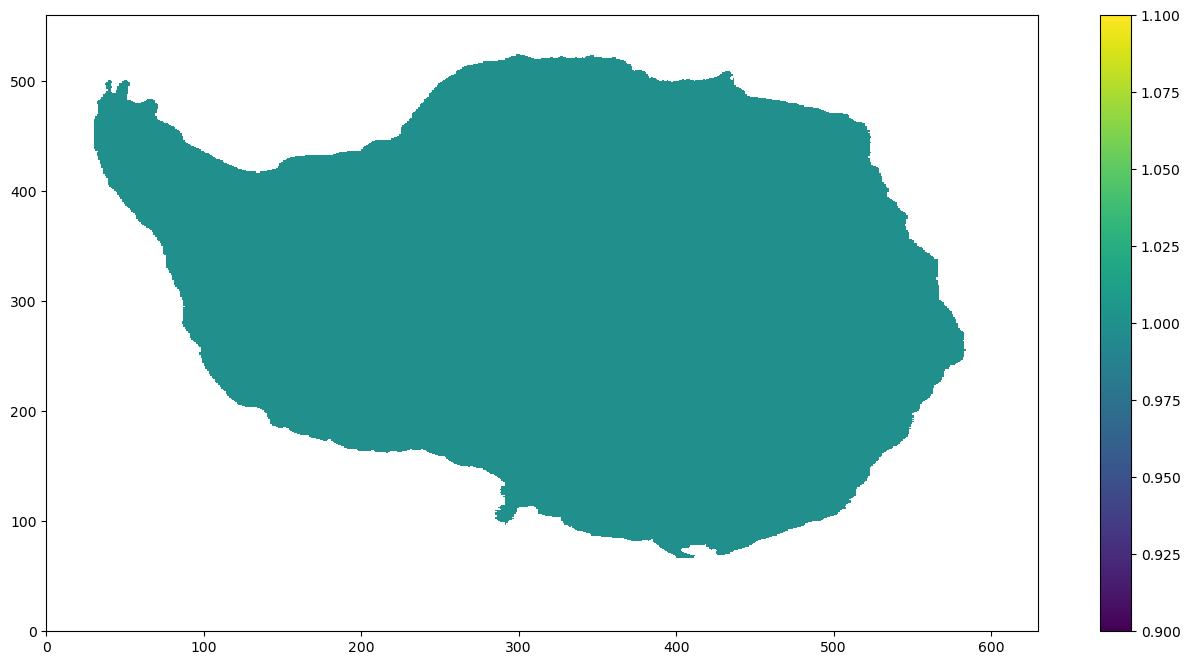

In [21]:
### mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))
mask_shelf2 = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))
# mask_shelf2 = ma.masked_where(contour_masked_above == 0, np.ones(h.shape))


plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_shelf2)
plt.colorbar()


## Fabio:
 -1000 (masked values), north of contour; 0 south of contour

##### Direction of cross-contour transport

Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour, !!actually below/south contour, Fabio) and -1000 (below contour, !!above/north contour, Fabio). This means the orientation of the contour can be determined. This is saved as mask_x_transport, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and mask_y_transport which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport ty_trans by the mask_y_transport gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).



In [22]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

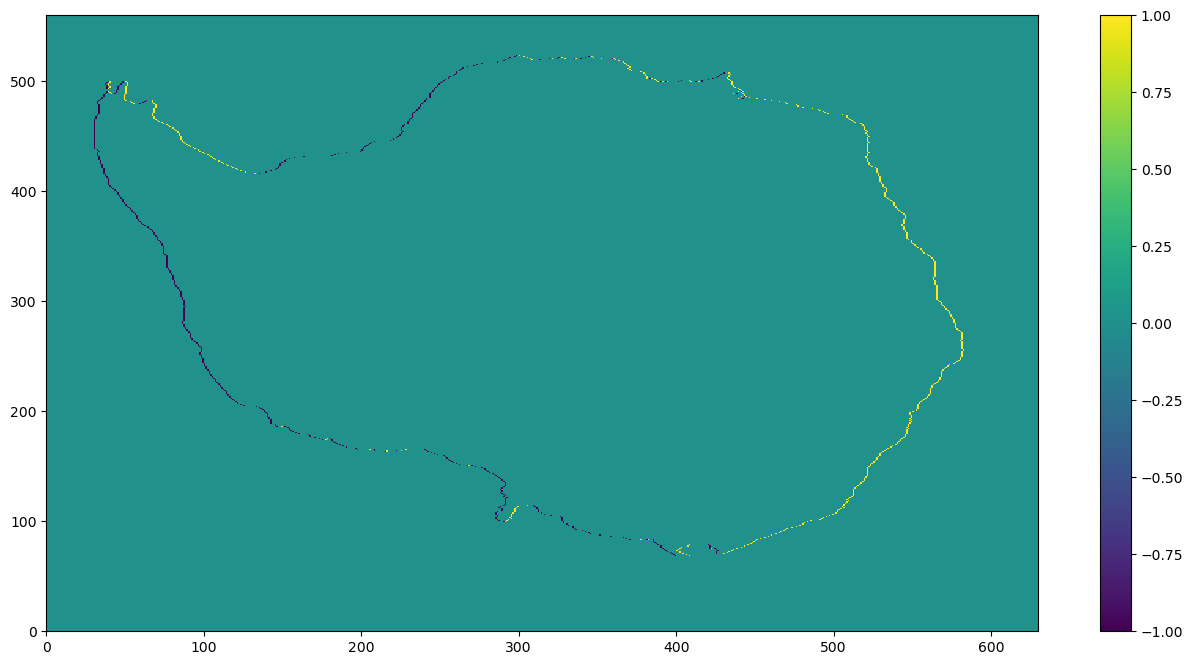

In [23]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport)
plt.colorbar();

As can be seen, in mask_x_transport there is yellow (+1) where eastward transport crosses the contour, and (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

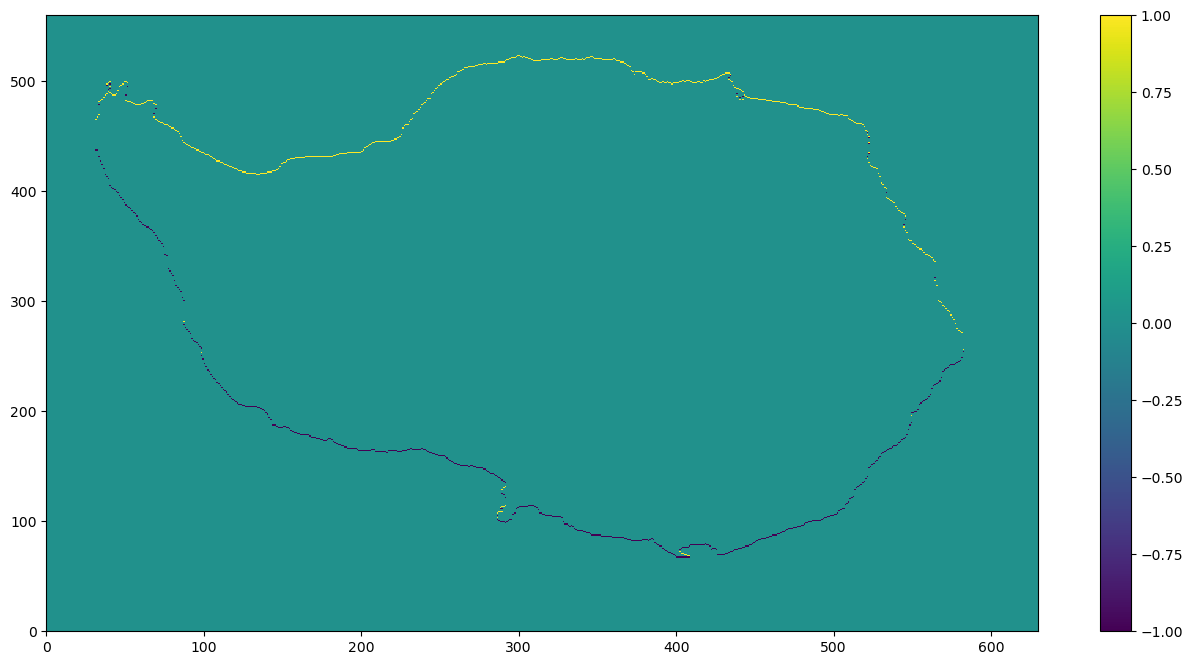

In [24]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_y_transport)
plt.colorbar();

Analogously, in mask_y_transport there is yellow (+1) where northward transport crosses the contour, and (-1) where southward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

We now proceed to calculate transports across the contour

In [25]:
print(pm.shape, pn.shape)

(560, 630) (560, 630)


In [26]:
# Now we need to interpolate the mask_x/y_transport to the corresponding lon/lat_u/v grids
# so we can multiply by the U/V transport

# re-grid from rho to u/v-grids
rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)

wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)


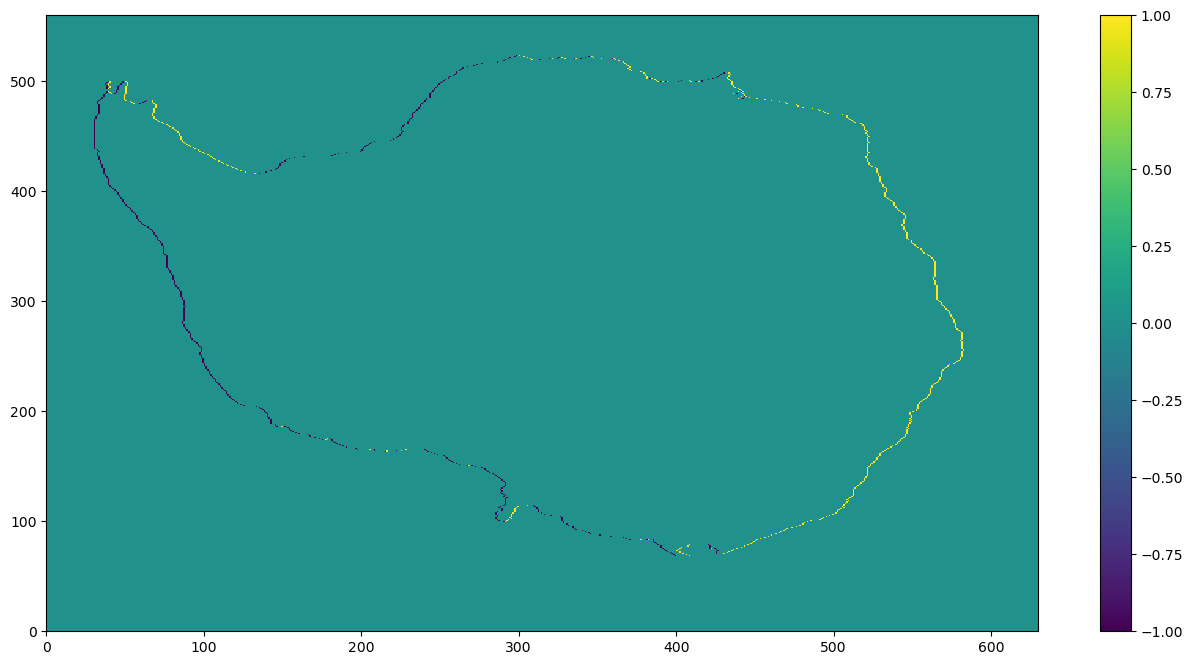

In [27]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport, cmap="viridis");
plt.colorbar()
plt.show()

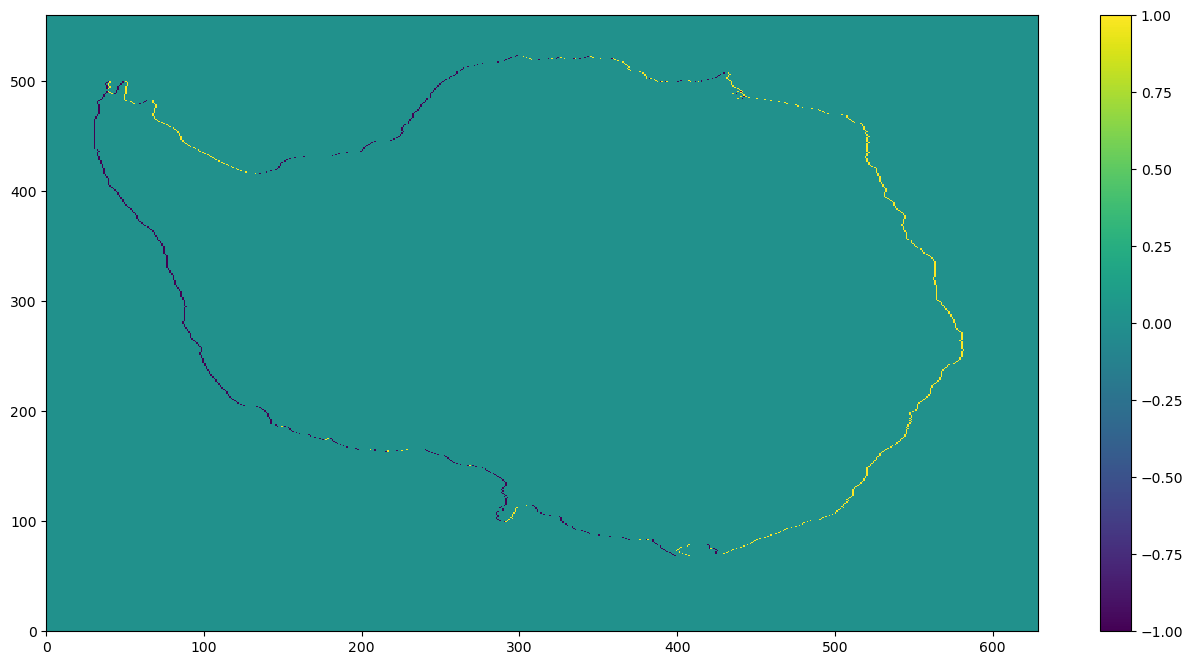

In [28]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport_Ugrd, cmap="viridis");
plt.colorbar()
plt.show()

In [29]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)


mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])


In [30]:
# rename dimensions as simply eta/xi
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})

### Stack contour data into 1D

In [31]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

### Finally, we can extract the coordinates of the contour index, and the distance, for a more meaningful "x" axis.

In [32]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.two
lon_along_contour = contour_ordering.one

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

### Code to extract distance in between contour coordinates, using length of diagonal if there is a bend.

Loop through the contour, determining if diagonal is required or not, and save the distance along each segment. Then, cumulatively sum the distances along each segment to get the distance from the first point.

If there is a bend in the contour, then half the diagonal distance is added to each side to avoid artifically inflating the along-contour distance metric, according to this diagram:

In [33]:
%%time
# pm/pn variables:

num_points = len(lat_along_contour)

# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = np.divide(1,pm)
dyt = np.divide(1,pn)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)#[0]
            # print(count, jj)
            distance_along_contour[count-1] = (dxu[jj])#[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)#[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])**2 + (dyt[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)#[0]
            distance_along_contour[count-1] = (dyt[jj])#[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)#[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])**2 + (dxu[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dxu[jj])#[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dyt[jj])#[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3


# --- Select the indices for axis labels of specific longitudes, 
# so we can plot transport vs distance but have longitude labels instead of length

distance_indices = np.zeros(9)

for i in np.arange(100, len(lon_along_contour.one)):
    # print(i)
    if (distance_indices[1]==0):
        if (lon_along_contour.one[i]>-160 and lon_along_contour.one[i]<-159):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.one[i]>-120 and lon_along_contour.one[i]<-119):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.one[i]>-80  and lon_along_contour.one[i]<-79):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if (lon_along_contour.one[i]>-40 and lon_along_contour.one[i]<-39):
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.one[i]>0 and lon_along_contour.one[i]<1):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.one[i]>40 and lon_along_contour.one[i]<41):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
    if (distance_indices[7]==0):
        if (lon_along_contour.one[i]>80 and lon_along_contour.one[i]<81):
            distance_indices[7] = lon_along_contour.contour_index.values[i]
    if (distance_indices[8]==0):
        if (lon_along_contour.one[i]>120 and lon_along_contour.one[i]<121):
            distance_indices[8] = lon_along_contour.contour_index.values[i]
            
            
# distance_indices[13] = len(lon_along_contour.contour_index.values)-1

CPU times: user 5.53 s, sys: 537 µs, total: 5.53 s
Wall time: 5.52 s


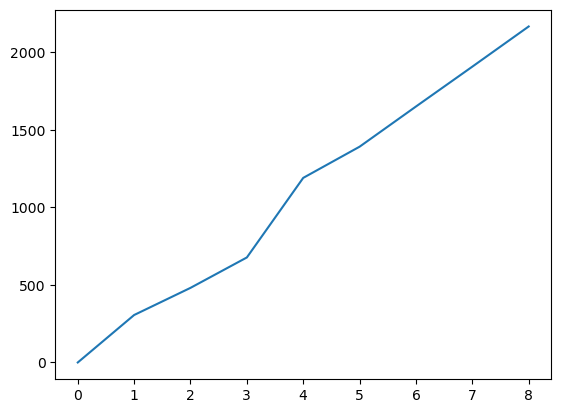

In [34]:
plt.plot(distance_indices)

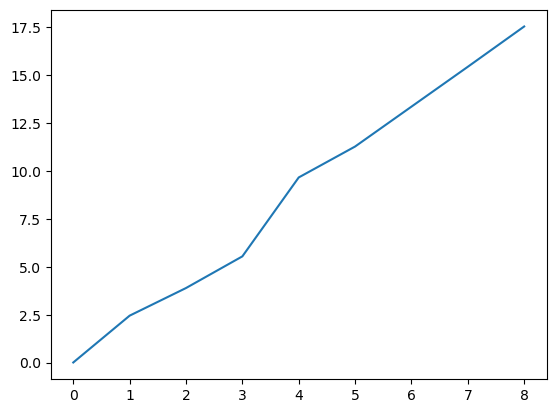

In [35]:
plt.plot(distance_along_contour[distance_indices.astype(int)[:]])


## save variables along the 1000-m isobath contour: lon/lat/distance_along_contour

In [37]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp'

lon_along_contour
lon_along_contour.to_netcdf(files_path + 'WAOM10_lon_along_1000m', mode='w', format="NETCDF4")

lat_along_contour
lat_along_contour.to_netcdf(files_path + 'WAOM10_lat_along_1000m', mode='w', format="NETCDF4")

## distance
coordinatesD=dict(contour_index_array=(['contour_index_array'], np.arange(0,len(contour_index_array))))

distance_along_contour_xr = xr.DataArray(distance_along_contour, coords = coordinatesD, dims = ['contour_index_array'])
distance_along_contour_xr.to_netcdf(files_path + 'WAOM10_dist_along_1000m', mode='w', format="NETCDF4")

coordinatesI=dict(lon_index=(['lon_index'], np.arange(0,9)))

distance_indices_xr = xr.DataArray(distance_indices, coords = coordinatesI, dims = ['lon_index'])
distance_indices_xr.to_netcdf(files_path + 'WAOM10_dist_indices_1000m', mode='w', format="NETCDF4")
